# Loop Hydrodynamics: High-frequency Heating
Compute loop evolution due to high-frequency nanoflares

In [3]:
import os
import sys
import subprocess
import multiprocessing

import numpy as np
from scipy.optimize import curve_fit,brentq
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors

import synthesizAR
from synthesizAR.interfaces.ebtel import EbtelInterface

sys.path.append('../../scripts/')
from constrained_heating_model import CustomHeatingModel

%matplotlib inline

First, restore the the field from the base model.

In [2]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

Next, configure our custom heating model which computes heating rates from a power-law distribution and observational constraints.

In [3]:
heating_options = {
    'duration': 200.0,
    'duration_rise': 100.0,
    'duration_decay': 100.0,
    'stress_level': 1.,
    'power_law_slope': -2.5,
    'frequency_parameter': 0.1
}

In [4]:
heating_model = CustomHeatingModel(heating_options)

And begin to setup our configuration for the loop simulations.

In [5]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 3e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [6]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/hydro_config/',
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/hydro_results/')

Now, run the heating model constrainer. This will use the whole field to compute the needed power-law distributions for each strand.

In [7]:
heating_model.constrain_distribution(field,
                                     tolerance=1e-3,
                                     ar_flux_constraint=1e7,
                                     sigma_increase=1.,sigma_decrease=1e-6,
                                     verbose=True)

Iteration 0 with error=5.179633134170323 and phi=6.179633134170323
Iteration 1 with error=0.999308668386423 and phi=0.0006913316135770147
Iteration 2 with error=0.9986469280318293 and phi=0.0013530719681706456
Iteration 3 with error=0.9972590892290423 and phi=0.0027409107709577066
Iteration 4 with error=0.9946408523324421 and phi=0.005359147667557879
Iteration 5 with error=0.9894667199136602 and phi=0.010533280086339776
Iteration 6 with error=0.9787988736164968 and phi=0.021201126383503282
Iteration 7 with error=0.9570514738117752 and phi=0.04294852618822481
Iteration 8 with error=0.9170760481540983 and phi=0.08292395184590169
Iteration 9 with error=0.8450204212910402 and phi=0.1549795787089598
Iteration 10 with error=0.705838215571897 and phi=0.29416178442810303
Iteration 11 with error=0.5085968880185258 and phi=0.49140311198147424
Iteration 12 with error=0.26001993969492987 and phi=0.7399800603050701
Iteration 13 with error=0.08151429798731602 and phi=0.918485702012684
Iteration 14 w

Check that we are obeying the constraint and take a look at the distribution of $\epsilon$ values, i.e. for each event, what fraction of the energy is being extracted from the field. This value should be close to 1 as the average flux over time and over all strands should be $\approx 10^7$ erg cm$^{-2}$ s$^{-1}$, the constraint from WN77 

In [94]:
tot = 0.
energies = []
loop_energies = []
for l in field.loops:
    energies += (heating_model.power_law_distributions[l.name] / ((l.field_strength.value.mean()**2)/8./np.pi)).tolist()
    loop_energies.append((heating_model.power_law_distributions[l.name] / ((l.field_strength.value.mean()**2)/8./np.pi)))
    tot += heating_model.power_law_distributions[l.name].sum()*l.full_length.to(u.cm).value
print(tot / len(field.loops) / base_config['total_time'] / 1e7)

1.00033458636


In [95]:
def mle(x,xmin,xmax,alpha_bounds=[1.1,10]):
    #define mle function
    def f_mle(alpha,xi,x_min,x_max):
        n = len(xi)
        term1 = -np.sum(np.log(xi))
        term2 = n/(alpha - 1.0)
        term3a = n/(x_min**(1.0-alpha) - x_max**(1.0-alpha))
        term3b = x_min**(1.0-alpha)*np.log(x_min) - x_max**(1.0-alpha)*np.log(x_max)
        return term1 + term2 + term3a*term3b
    
    x0,r = brentq(f_mle,alpha_bounds[0],alpha_bounds[1],args=(x,xmin,xmax),full_output=True)
    if r.converged:
        return x0
    else:
        print('Minimization not sucessful. Returning None')
        return None

(1, 50000.0)

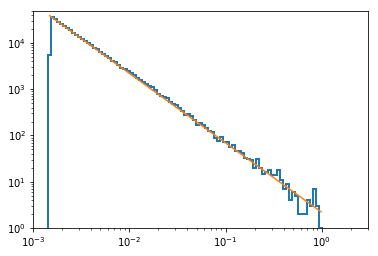

In [99]:
hist,bins,_ = plt.hist(np.array(energies),
                       bins=np.logspace(-3,0.1,100),
                       lw=2,histtype='step',density=False,);
def fit_func(x,a,b):
    return a*x + b
power_law_slopes = np.zeros((len(field.loops),))
for i,le in enumerate(loop_energies):
    power_law_slopes[i] = mle(le,le.min(),le.max(),)
bin_centers = (bins[1:] + bins[:-1])/2.
bin_centers = bin_centers[hist>0]
popt,pcov = curve_fit(fit_func, np.log10(bin_centers), np.log10(hist[hist>0]),)
plt.plot(bin_centers,(10.**popt[1])*(bin_centers**popt[0]),color='C1')
#plt.axvline(x=0.3,ls=':',color='k')
#plt.axvline(x=0.1,ls=':',color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3,3)
plt.ylim(1,5e4)
#plt.title(r'$\alpha$={:.3f}'.format(popt[0]));

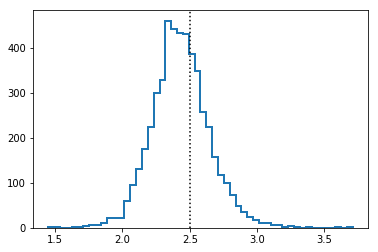

In [100]:
plt.hist(power_law_slopes,bins='scott',histtype='step',lw=2);
plt.axvline(x=2.5,ls=':',color='K')

And finally configure the loop simulations.

In [10]:
field.configure_loop_simulations(ebtel_interface)

FloatProgress(value=0.0)

Now run the models

In [11]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [12]:
pool = multiprocessing.Pool()

In [13]:
runs = pool.map_async(ebtel_runner,field.loops)
runs.wait()

And store the outputs

In [14]:
field.load_loop_simulations(ebtel_interface,
                            savefile='/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/loop_parameters.h5'
                           )

FloatProgress(value=0.0)

In [29]:
field = synthesizAR.Field.restore(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/field_checkpoint/',lazy=True)

In [30]:
from synthesizAR.instruments import InstrumentSDOAIA
from scipy.interpolate import splev

In [37]:
T = np.logspace(5.5,7.5,10000)
aia = InstrumentSDOAIA([0,1]*u.s, None)


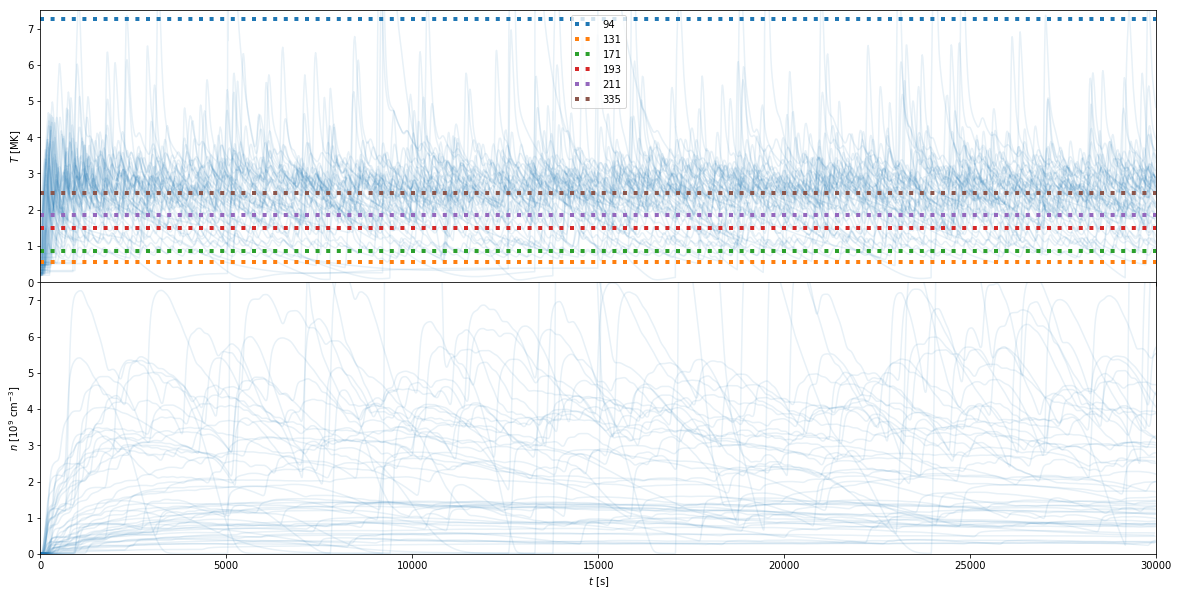

In [38]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::100]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.1)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
for i,c in enumerate(aia.channels):
    TC = T[np.argmax(splev(T,c['temperature_response_spline']))]*u.K
    axes[0].axhline(y=TC.to(u.MK).value,ls=':',label=c['name'],color=f'C{i}',lw=4)
axes[0].set_xlim(0,3e4)
axes[0].set_ylim(0,7.5)
axes[1].set_ylim(0,7.5)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');
axes[0].legend()

In [55]:
Tbar = u.Quantity(np.concatenate([l.electron_temperature[:,0].value for l in field.loops],), 'K')

In [40]:
Tsigma = u.Quantity([l.electron_temperature[:,0].std().value for l in field.loops], 'K')

94: 7.266681637383885 MK
131: 0.5686243881743701 MK
171: 0.8646566468568793 MK
193: 1.5019921634391509 MK
211: 1.8538594610019996 MK
335: 2.4586067459396035 MK


(0, 6)

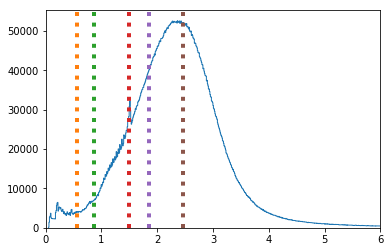

In [59]:
plt.hist(Tbar.to(u.MK).value,bins='fd',histtype='step');
for i,c in enumerate(aia.channels):
    TC = T[np.argmax(splev(T,c['temperature_response_spline']))]*u.K
    print(f'{c["name"]}: {TC.to(u.MK)}')
    plt.axvline(x=TC.to(u.MK).value,ls=':',label=c['name'],color=f'C{i}',lw=4)
plt.xlim(0,6)

In [61]:
np.median(Tbar)

<Quantity 2318634. K>

In [43]:
Tbar.mean().to(u.MK)

<Quantity 2.41477998 MK>

In [44]:
Tsigma.mean().to(u.MK)

<Quantity 0.7674921 MK>

In [18]:
field.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/field_checkpoint')